In [2]:
import os
import glob
import h5py
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.models import Model
import cv2
from keras.utils import to_categorical
color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


In [3]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [4]:
from keras.models import load_model

In [5]:
import tensorflow as tf

### Loading model trained on x-rays samples

In [6]:
model = load_model('../models/covid19-pneumonia.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Loading test data

In [21]:
data_dir = Path('../images')

test_dir = data_dir / 'test'
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'
covid19_cases_dir = test_dir / 'COVID19'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
covid19_cases = covid19_cases_dir.glob('*.jpeg')
covid19_cases2 = covid19_cases_dir.glob('*.jpg')
covid19_cases3 = covid19_cases_dir.glob('*.png')


### How test data looks like ?

*********************************************************************

In [50]:
images_folder_path = ''

In [ ]:
folders = ['COVID19' , 'NORMAL' , 'PNEUMONIA']
covid_list = []

for folder in folders:
    current_folder = folder
    basepath = images_folder_path + '/' + current_folder
    for entry in os.listdir(basepath):
        filepath = os.path.join(basepath, entry)
        entry = [entry,current_folder,filepath]
        covid_list.append(entry)

In [ ]:
df = pd.DataFrame(covid_list)

In [ ]:
df.columns = (['filename', 'filefolder', 'filepath'])

In [ ]:
covid_samples = (df[df['filefolder']== 'COVID19']['filepath'].iloc[:5]).tolist()
normal_samples = (df[df['filefolder']== 'NORMAL']['filepath'].iloc[:5]).tolist()
pneumonia_samples = (df[df['filefolder']== 'PNEUMONIA']['filepath'].iloc[:5]).tolist()
samples = covid_samples + normal_samples+pneumonia_samples
del covid_samples, normal_samples

*********************************************************************

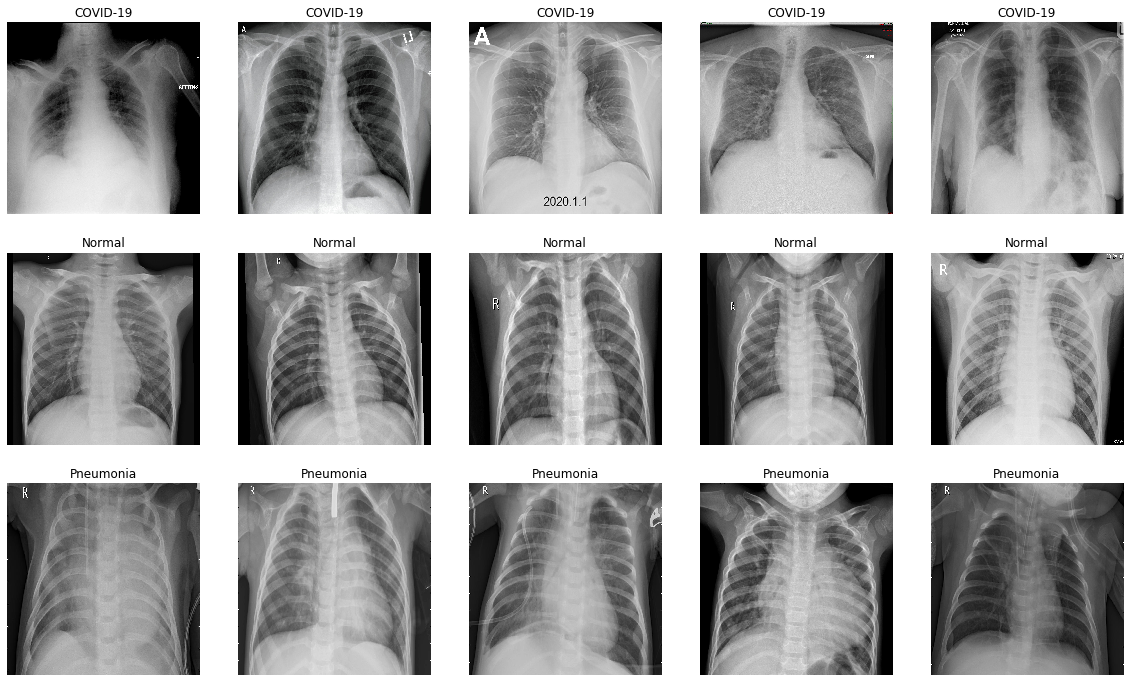

In [44]:
f, ax = plt.subplots(3,5, figsize=(20,10))
for i in range(len(samples)):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("COVID-19")
    elif i>4 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Pneumonia")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Prepare data for prediction

In [49]:
def case_xray(generator, label_class, ):
    img = cv2.imread(str(generator))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(label_class, num_classes=3)
    return img, label

In [23]:
test_data = []
test_labels = []

# Normal cases
for img in normal_cases:
    xray,label = case_xray(img, 0)
    test_data.append(xray)
    test_labels.append(label)           
# Pneumonia cases        
for img in pneumonia_cases:
    xray,label = case_xray(img, 1)
    test_data.append(xray)
    test_labels.append(label)
# COVID19 cases JPG/JPEG/PNG       
for img in covid19_cases:
    xray,label = case_xray(img, 2)
    test_data.append(xray)
    test_labels.append(label)
    
    
for img in covid19_cases2:
    xray,label = case_xray(img, 2)
    test_data.append(xray)
    test_labels.append(label)


for img in covid19_cases3:
    xray,label = case_xray(img, 2)
    test_data.append(xray)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)



### Prediction 

In [25]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)
orig_test_labels = np.argmax(test_labels, axis=-1)

test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Accuracy on test set: ", test_score)

70/70 [==============================] - 9s 123ms/step
Accuracy on test set:  0.9523810148239136


In [26]:
confusion_matrix(orig_test_labels, preds)

array([[16,  4,  0],
       [ 1, 29,  0],
       [ 0,  0, 20]])

### How did the model do?

([<matplotlib.axis.YTick at 0x7ff01c7c3390>,
 <a list of 3 Text yticklabel objects>)

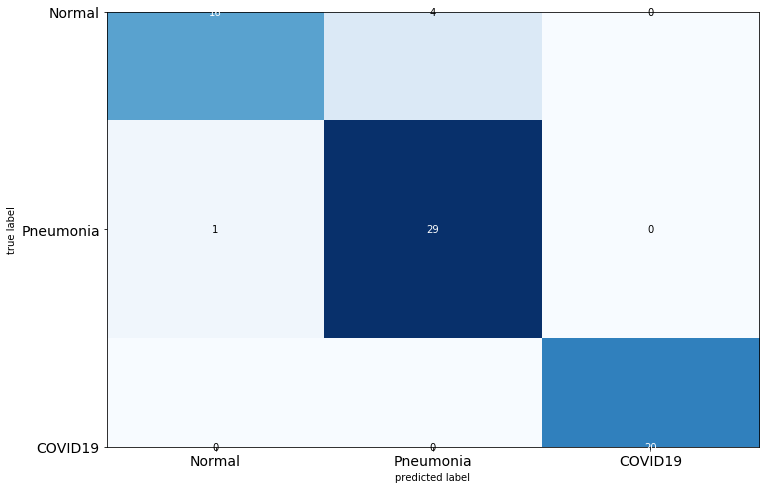

In [46]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
# plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Pneumonia', 'COVID19'], fontsize=14)
plt.yticks(range(3), ['Normal', 'Pneumonia', 'COVID19'], fontsize=14)
# plt.show()